In [59]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from mpl_toolkits.mplot3d import Axes3D
from tools.setup.setup import tools_home_dir, home_dir
import astropy.io.fits as fits
shapedir = home_dir()+'output/buzzard/halo_shape/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/miscentering/'
buzzdir = home_dir() + 'output/buzzard/'
toolsdir = tools_home_dir()
homedir = home_dir()

import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

from repo.halo_shape.halo_shape_stats_backend import kmeans_stats, student_t_test
from repo.halo_shape.read_shape_param import halo_bin_stat, read_shape_param

## Import catalogs

In [60]:
from repo.halo_shape.read_shape_param import read_shape_param
import numpy.lib.recfunctions as rfn

filename = homedir +'output/buzzard/halo_shape/halo_shape_allz_adapt.npy'
redM_data = np.load(filename)
redM_data = redM_data.view(np.recarray)

print "Number of halos in the redM catalog is ", len(redM_data)
print redM_data.dtype

#Apply mass cut
masscut = np.where(redM_data.M200b > 1e13)
redM_data = redM_data[masscut]
print "After mass cut number of halos is ", len(redM_data)

Number of halos in the redM catalog is  23997
(numpy.record, [('halos_ID', '<i4'), ('richness', '<f4'), ('M200b', '<f4'), ('Rvir', '<f4'), ('redshift', '<f4'), ('axes_len', '<f4', (3,)), ('axes_dir', '<f4', (3, 3)), ('halos_dir', '<f4', (3,)), ('halos_RA', '<f4'), ('halos_DEC', '<f4'), ('converge', '<i4')])
After mass cut number of halos is  23997


In [61]:
#Miscentering cut
import pickle

#Loading the centered/miscentered halo IDs
cent_file = homedir + 'output/miscentering/cent_haloID.data'
miscent_file = homedir + 'output/miscentering/miscent_haloID.data'

file = open(cent_file,'r')
cent_haloID = pickle.load(file)
file = open(miscent_file,'r')
miscent_haloID = pickle.load(file)

#Splitting the halos 
cent_data = redM_data
cent_ind = [i for (i,x) in enumerate(redM_data.halos_ID) if x in cent_haloID]
miscent_ind = [i for (i,x) in enumerate(redM_data.halos_ID) if x in miscent_haloID]

redM_cent = redM_data[cent_ind]
redM_miscent = redM_data[miscent_ind]

print len(redM_cent), len(redM_miscent)
print redM_cent.dtype


10748 9211
(numpy.record, [('halos_ID', '<i4'), ('richness', '<f4'), ('M200b', '<f4'), ('Rvir', '<f4'), ('redshift', '<f4'), ('axes_len', '<f4', (3,)), ('axes_dir', '<f4', (3, 3)), ('halos_dir', '<f4', (3,)), ('halos_RA', '<f4'), ('halos_DEC', '<f4'), ('converge', '<i4')])


### Extracting info from centered

In [62]:
##Shorthand name for relevant halo/redM parameters
print "Before convergence cut number of halos is ", len(redM_cent)
halos_ID_cent, q_cent, s_cent, cos_i_cent = read_shape_param(np.array(redM_cent), convcut=True)
#Choose only convergent halos
conv_cut = [i for (i,x) in enumerate(redM_cent.halos_ID) if x in halos_ID_cent]
redM_cent = redM_cent[conv_cut]
print "After convergence cut number of halos is ", len(redM_cent)

richness = redM_cent.richness
halos_M  = redM_cent.M200b

coord_cent = np.zeros( (len(redM_cent),2))
coord_cent[:,0] = redM_cent.halos_RA; coord_cent[:,1] = redM_cent.halos_DEC

print "Halo mass range is from ", min(np.log10(halos_M)), max(np.log10(halos_M))

Before convergence cut number of halos is  10748
After convergence cut number of halos is  10699
Halo mass range is from  13.703395 15.356619


### Binning by cos(i) and \lambda

In [63]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind_cent = halo_bin_stat(cos_i_cent, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind_cent = halo_bin_stat(richness, lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q_cent))]

Maximum richness after cuts is  303.044


In [64]:
#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_binned_cent = [None]*num_bins
lnl_binned_cent = [None]*num_bins

lnl_cent = np.log(richness)
lnM200b_cent = np.log(halos_M)

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_binned_cent[i] = np.log(halos_M[cosi_bins_ind_cent[i]])
    lnl_binned_cent[i] = np.log(richness[cosi_bins_ind_cent[i]])

### Extracting info from miscentered

In [65]:
##Shorthand name for relevant halo/redM parameters
print "Before convergence cut number of halos is ", len(redM_miscent)
halos_ID_miscent, q_miscent, s_miscent, cos_i_miscent = read_shape_param(np.array(redM_miscent), convcut=True)
#Choose only convergent halos
conv_cut = [i for (i,x) in enumerate(redM_miscent.halos_ID) if x in halos_ID_miscent]
redM_miscent = redM_miscent[conv_cut]
print "After convergence cut number of halos is ", len(redM_miscent)

richness = redM_miscent.richness
halos_M  = redM_miscent.M200b

coord_miscent = np.zeros( (len(redM_miscent),2))
coord_miscent[:,0] = redM_miscent.halos_RA; coord_miscent[:,1] = redM_miscent.halos_DEC

print "Halo mass range is from ", min(np.log10(halos_M)), max(np.log10(halos_M))

Before convergence cut number of halos is  9211
After convergence cut number of halos is  9129
Halo mass range is from  13.699187 15.531862


In [66]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind_miscent = halo_bin_stat(cos_i_miscent, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind_miscent = halo_bin_stat(richness, lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q_miscent))]

Maximum richness after cuts is  247.15


In [67]:
#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_binned_miscent = [None]*num_bins
lnl_binned_miscent = [None]*num_bins

lnl = np.log(richness)
lnM200b = np.log(halos_M)

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_binned_miscent[i] = np.log(halos_M[cosi_bins_ind_miscent[i]])
    lnl_binned_miscent[i] = np.log(richness[cosi_bins_ind_miscent[i]])

## Shape information

### Statistical information

In [68]:
km_ncen = 40

#centered
all_ind = [np.arange(len(q_cent))]
q_cent_se, q_cent_mean = kmeans_stats(km_ncen, coord_cent, q_cent, all_ind)
s_cent_se, s_cent_mean = kmeans_stats(km_ncen, coord_cent, s_cent, all_ind)
cosi_cent_se, cosi_cent_mean = kmeans_stats(km_ncen, coord_cent, cos_i_cent, all_ind)

#miscentered
all_ind = [np.arange(len(q_miscent))]
q_miscent_se, q_miscent_mean = kmeans_stats(km_ncen, coord_miscent, q_miscent, all_ind)
s_miscent_se, s_miscent_mean = kmeans_stats(km_ncen, coord_miscent, s_miscent, all_ind)
cosi_miscent_se, cosi_miscent_mean = kmeans_stats(km_ncen, coord_miscent, cos_i_miscent, all_ind)

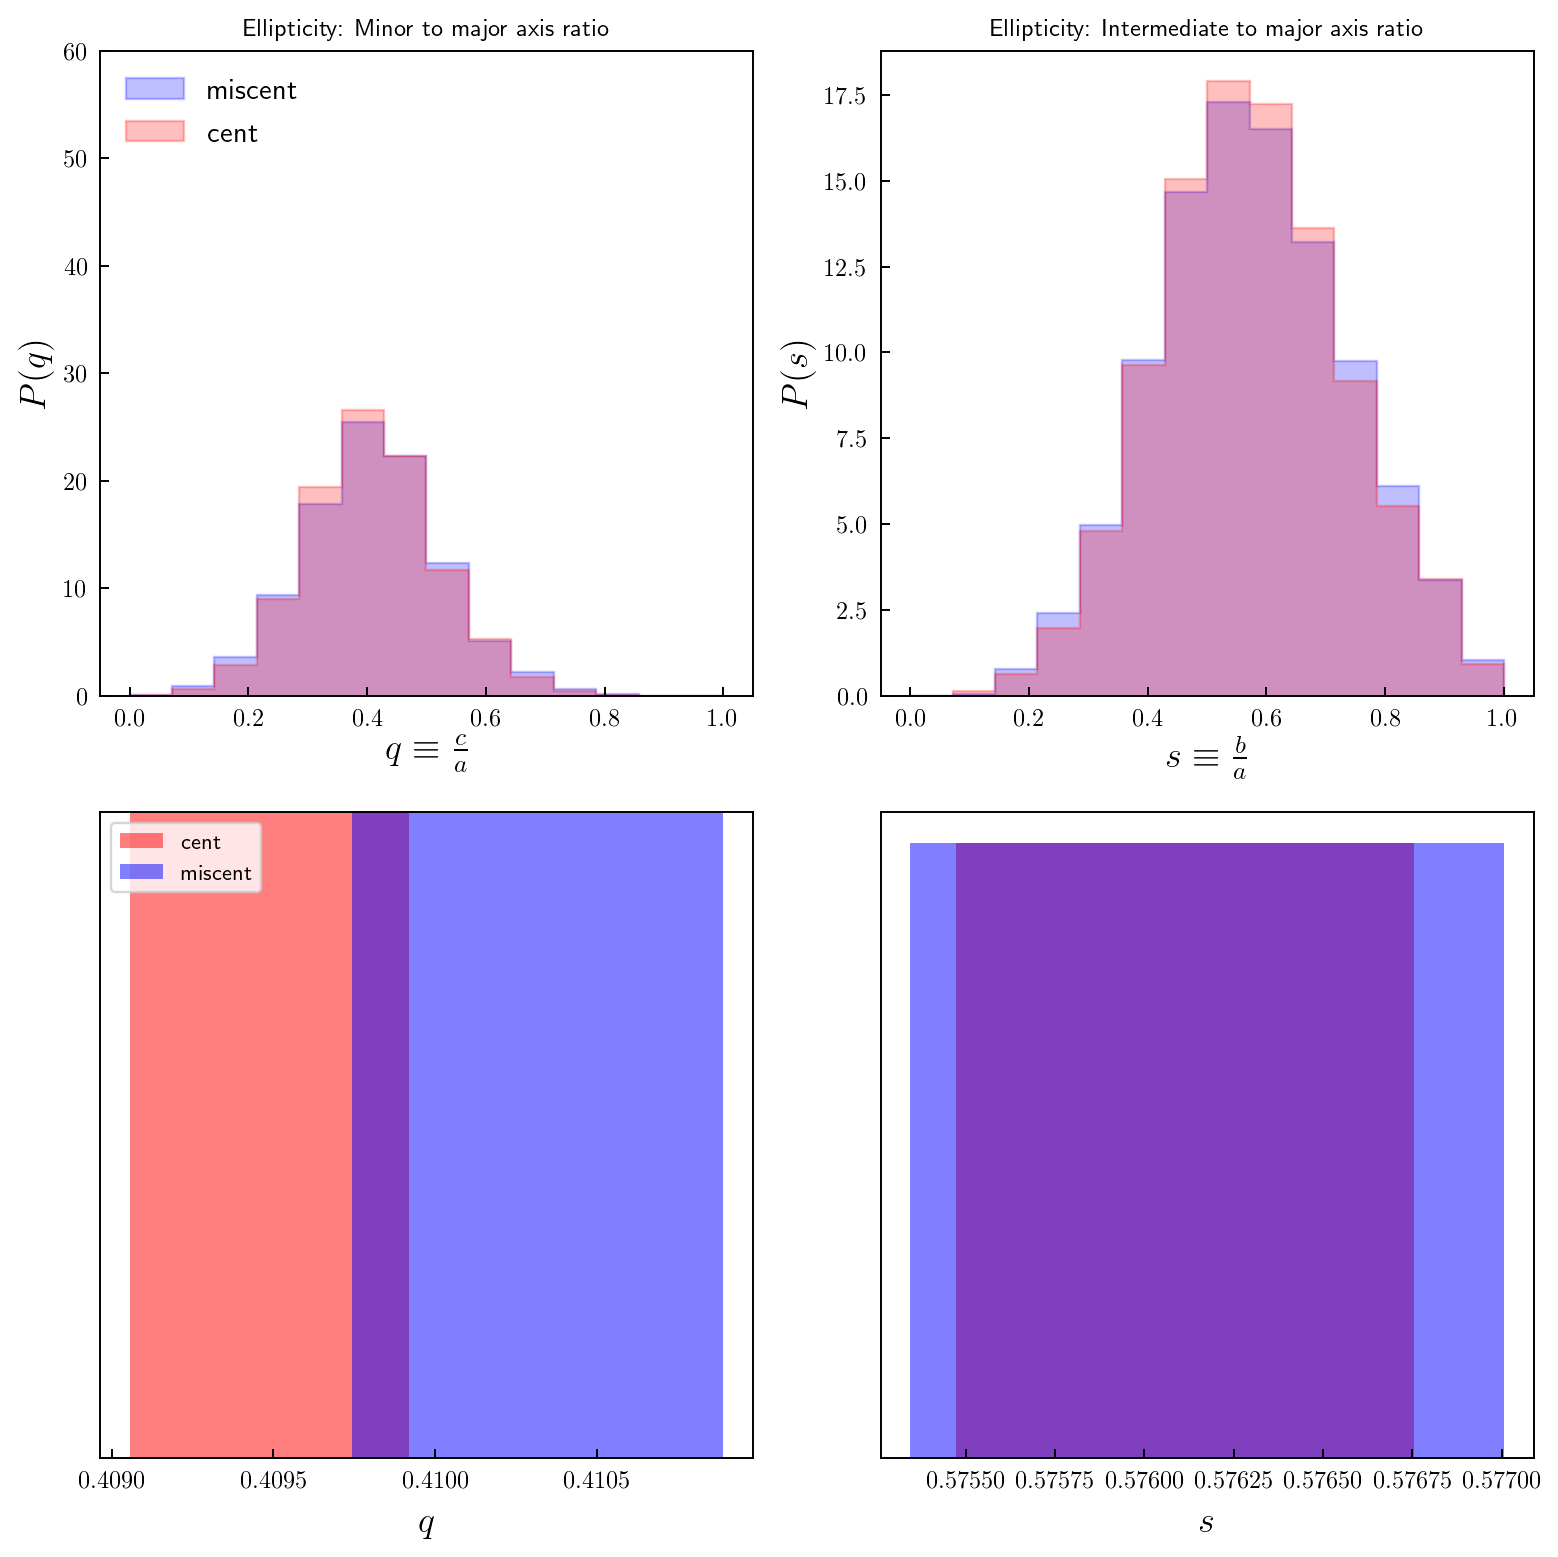

In [73]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(9,9))
num_bin = np.linspace(0.0,1.0,15)

#Plotting miscentered halos
weights = np.ones_like(q_miscent)/(len(q_miscent)) * 100
axs[0,0].hist(q_miscent, num_bin, density=False, weights=weights, fill=True, histtype='step', color='blue', \
               label='miscent', alpha=0.25) 
weights = np.ones_like(s_miscent)/(len(s_miscent)) * 100
a =axs[0,1].hist(s_miscent, num_bin, density=False, weights=weights, fill=True, histtype='step', color='blue', \
               label='miscent', alpha=0.25) 
    
    
#Plotting centered halos
weights = np.ones_like(q_cent)/(len(q_cent)) * 100
axs[0,0].hist(q_cent, num_bin, density=False, weights=weights, fill=True, histtype='step', color='red', \
               label='cent', alpha=0.25) 
weights = np.ones_like(s_cent)/(len(s_cent)) * 100
a =axs[0,1].hist(s_cent, num_bin, density=False, weights=weights, fill=True, histtype='step', color='red', \
               label='cent', alpha=0.25) 


#Plot config   
axs[0,0].set_xlabel(r'$q \equiv \frac{c}{a}$', size=15)
axs[0,0].set_ylabel('$P(q)$', size=15)
axs[0,0].set_title(r'Ellipticity: Minor to major axis ratio', fontsize=10)

axs[0,0].set_ylim((0,60))
axs[0,0].legend(loc='upper left', fontsize=12, frameon=False)

axs[0,1].set_xlabel(r'$s \equiv \frac{b}{a}$', size=15)
axs[0,1].set_ylabel('$P(s)$', size=15)
axs[0,1].set_title(r'Ellipticity: Intermediate to major axis ratio', fontsize=10)
#plt.savefig('ellipticity_dist_053018.png')


#Plotting the mean q, s

#Plot config
num_bins = len(cosi_bins)
yticks = np.linspace(0.2,0.8 , num_bins)
yticklabels = []
xlabels = [r'$q$', r'$s$', r'$\cos(i)$']
for i, cosi_bin_i in enumerate(cosi_bins):
    yticklabels_i = r'$\cos(i) \in [{:.1f}, {:.1f})$'.format(cosi_bin_i[0], cosi_bin_i[1])
    yticklabels.append(yticklabels_i)
    
#Plotting mean q,s with errors    
axs[1,0].bar(q_cent_mean, height=1, width=q_cent_se, alpha=0.5, color='red',label='cent')
axs[1,0].bar(q_miscent_mean, height=1, width=q_miscent_se, alpha=0.5, color='blue',label='miscent')
axs[1,1].bar(s_cent_mean, height=1, width=s_cent_se, alpha=0.5, color='red',label='cent')
axs[1,1].bar(s_miscent_mean, height=1, width=s_miscent_se, alpha=0.5, color='blue',label='miscent')

axs[1,1].set_xlabel(xlabels[1], size=15)
axs[1,0].set_xlabel(xlabels[0], size=15)
axs[1,1].set_yticks([])
axs[1,0].set_ylim((0.0,1.0))

#Legend and ticklabels
axs[1,0].legend(fontsize=9, loc='upper left')
axs[1,0].set_yticks([])
#axs[1,0].set_yticks(yticks)
#axs[1,0].set_yticklabels(yticklabels, fontsize=15)

    
plt.show()   

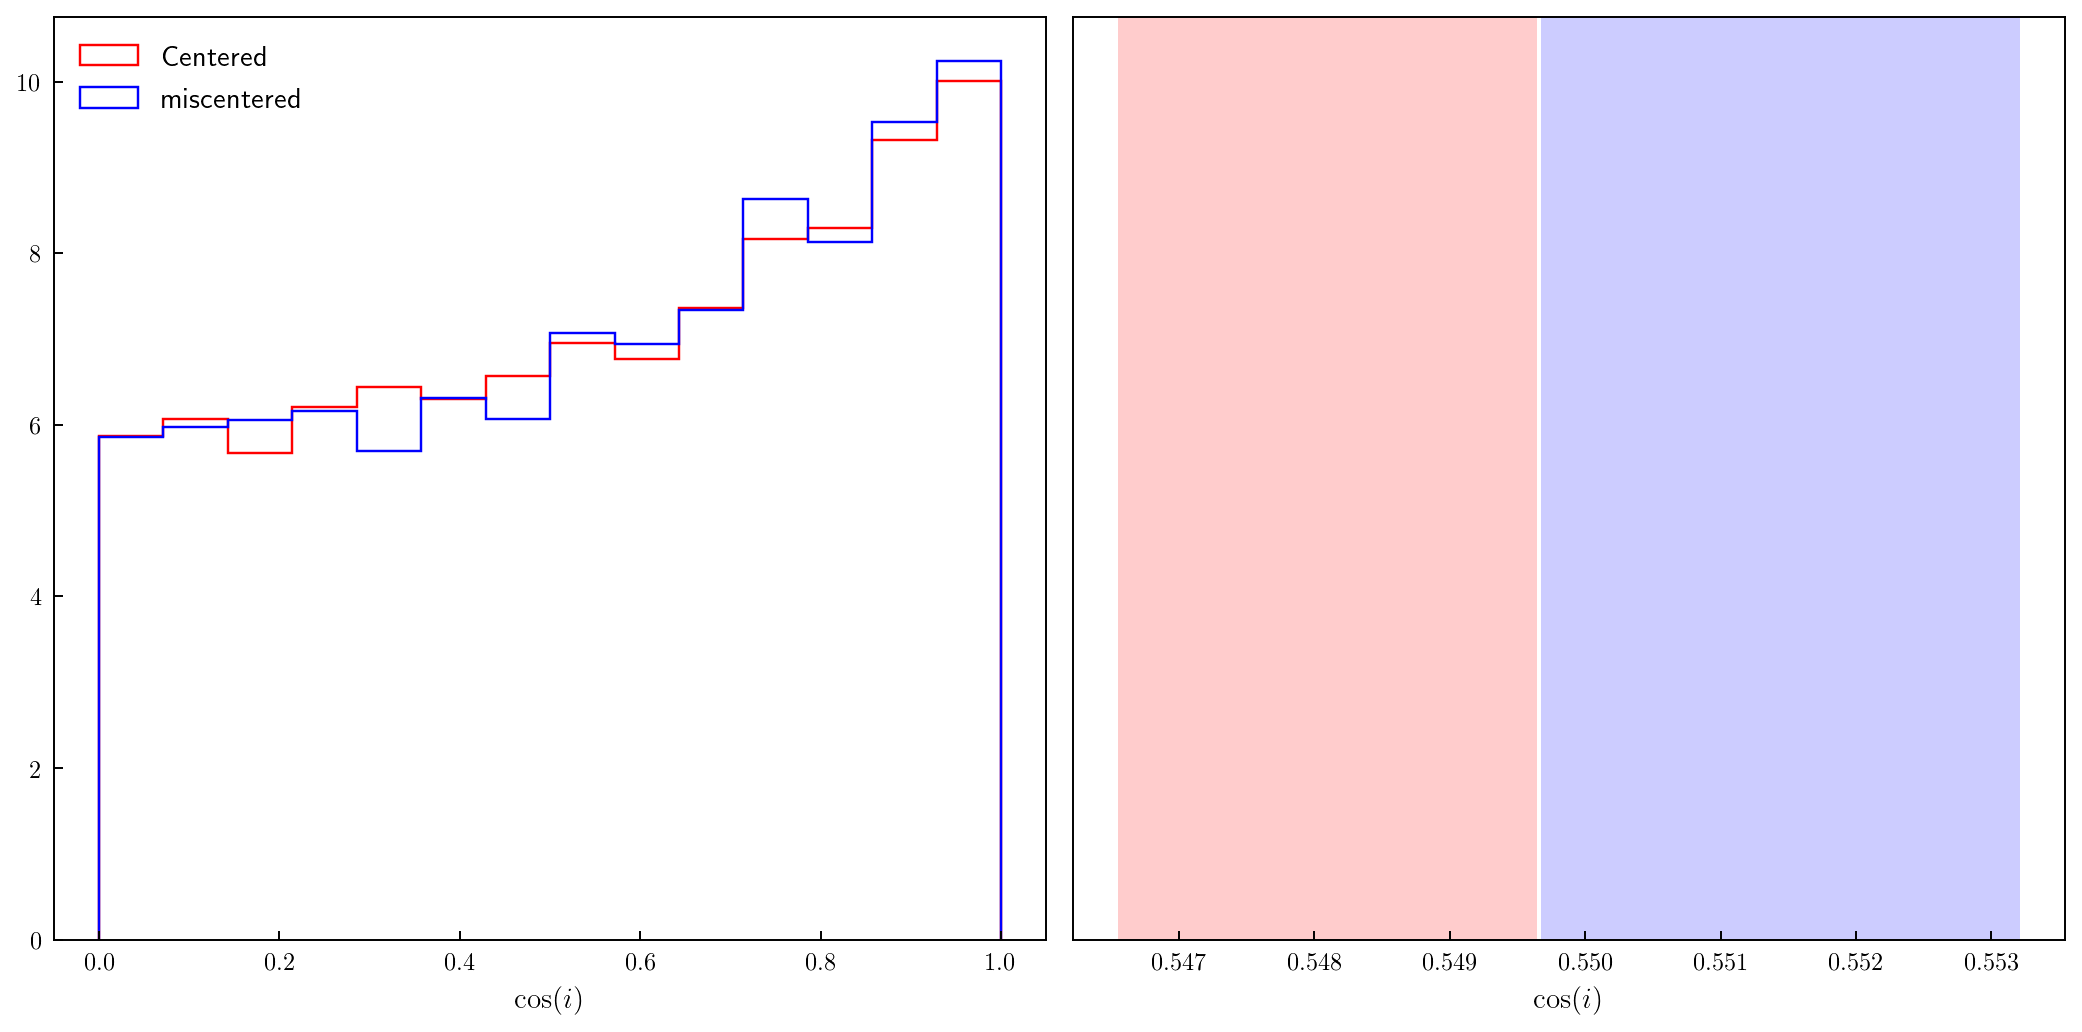

In [70]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(12,6))
num_bin = np.linspace(0.0,1.0,15)

####Centered halos########
weights_cent = np.ones_like(cos_i_cent, dtype=float)/len(cos_i_cent)* 100
axs[0].hist(cos_i_cent, num_bin, density=False, fill=False, weights=weights_cent, histtype='step', label="Centered", color='red') 
axs[1].bar(cosi_cent_mean, height=1, width=cosi_cent_se, alpha=0.2, color='red',label='cent')

####miscentered halos########
lmda_bin_num = len(lmda_bins_ind_miscent)
weights_miscent = np.ones_like(cos_i_miscent, dtype=float)/len(cos_i_miscent)* 100
axs[0].hist(cos_i_miscent, num_bin, density=False, fill=False, weights=weights_miscent, histtype='step', label="miscentered", color='blue') 
axs[1].bar(cosi_miscent_mean, height=1, width=cosi_miscent_se, alpha=0.2, color='blue',label='miscent')



axs[0].set_xlabel(xlabels[2], fontsize=12)
axs[1].set_xlabel(xlabels[2], fontsize=12)
axs[1].set_yticks([])
axs[1].set_ylim((0.0,1.0))
    

#axs.set_ylim((0,60))
axs[0].legend(loc='upper left', fontsize=12, frameon=False)

plt.show()
    